In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import json
import os
import numpy as np
import matplotlib.pyplot as plt

In [46]:
class HandLandmarkDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.classes = os.listdir(root_dir)
        self.file_list = []
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for file_name in os.listdir(class_dir):
                self.file_list.append((os.path.join(class_dir, file_name), class_idx))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path, class_idx = self.file_list[idx]
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        # Extract x, y, z coordinates from each landmark
        landmarks = data[0]  # Assuming the first (and only) item in the list is the landmarks
        flattened_landmarks = []
        for landmark in landmarks:
            flattened_landmarks.extend([landmark['x'], landmark['y'], landmark['z']])
        
        # Convert to tensor
        landmarks_tensor = torch.tensor(flattened_landmarks, dtype=torch.float32)
        
        return landmarks_tensor, class_idx
    
    def get_class_names(self):
        return self.classes

In [52]:
class HandLandmarkModel(nn.Module):
    def __init__(self, input_size=63, num_classes=37):
        super(HandLandmarkModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Check if the input is a single sample and unsqueeze if necessary
        if x.dim() == 1:
            x = x.unsqueeze(0)
        
        x = self.fc1(x)
        x = self.bn1(x) if x.size(0) > 1 else x  # Apply BatchNorm only for batch size > 1
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn2(x) if x.size(0) > 1 else x
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.bn3(x) if x.size(0) > 1 else x
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc4(x)
        x = self.bn4(x) if x.size(0) > 1 else x
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc5(x)
        return F.log_softmax(x, dim=1)


In [ ]:
# Create a sample input tensor
sample_input = torch.randn(63)  # Single sample
batch_input = torch.randn(32, 63)  # Batch of 32 samples

# Initialize the model
model = HandLandmarkModel()

# Forward pass with single sample
output_single = model(sample_input)

# Forward pass with batch
output_batch = model(batch_input)

print(f"Single input shape: {sample_input.shape}")
print(f"Single output shape: {output_single.shape}")
print(f"Batch input shape: {batch_input.shape}")
print(f"Batch output shape: {output_batch.shape}")
print(f"Model architecture:\n{model}")

In [28]:
def infer(model, input_data, device):
    model.to(device)
    input_tensor = torch.FloatTensor(input_data).unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    return predicted_class, probabilities.squeeze().cpu().numpy()

def load_model(model_path, input_size, num_classes):
    model = HandLandmarkModel(input_size, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model

ModelTrainer initialized with device: cuda
CUDA device: NVIDIA GeForce GTX 1070
CUDA available: True
Current CUDA device: 0
Training on device: cuda
Model is on device: cpu
Moving model to cuda
After moving, model is on device: cuda:0


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6189 | train_acc: 0.0393 | test_loss: 3.3976 | test_acc: 0.1719 | lr: 0.000100
Epoch: 2 | train_loss: 3.4126 | train_acc: 0.0894 | test_loss: 3.1724 | test_acc: 0.4128 | lr: 0.000100
Epoch: 3 | train_loss: 3.2522 | train_acc: 0.1566 | test_loss: 2.9929 | test_acc: 0.5299 | lr: 0.000100
Epoch: 4 | train_loss: 3.0890 | train_acc: 0.2033 | test_loss: 2.8368 | test_acc: 0.5872 | lr: 0.000100
Epoch: 5 | train_loss: 2.9445 | train_acc: 0.2776 | test_loss: 2.6883 | test_acc: 0.6354 | lr: 0.000100
Epoch: 6 | train_loss: 2.8218 | train_acc: 0.3209 | test_loss: 2.5732 | test_acc: 0.6380 | lr: 0.000100
Epoch: 7 | train_loss: 2.6843 | train_acc: 0.3790 | test_loss: 2.4071 | test_acc: 0.6510 | lr: 0.000100
Epoch: 8 | train_loss: 2.5851 | train_acc: 0.3972 | test_loss: 2.3142 | test_acc: 0.6628 | lr: 0.000100
Epoch: 9 | train_loss: 2.4474 | train_acc: 0.4640 | test_loss: 2.1508 | test_acc: 0.7031 | lr: 0.000100
Epoch: 10 | train_loss: 2.3454 | train_acc: 0.4772 | test_loss: 

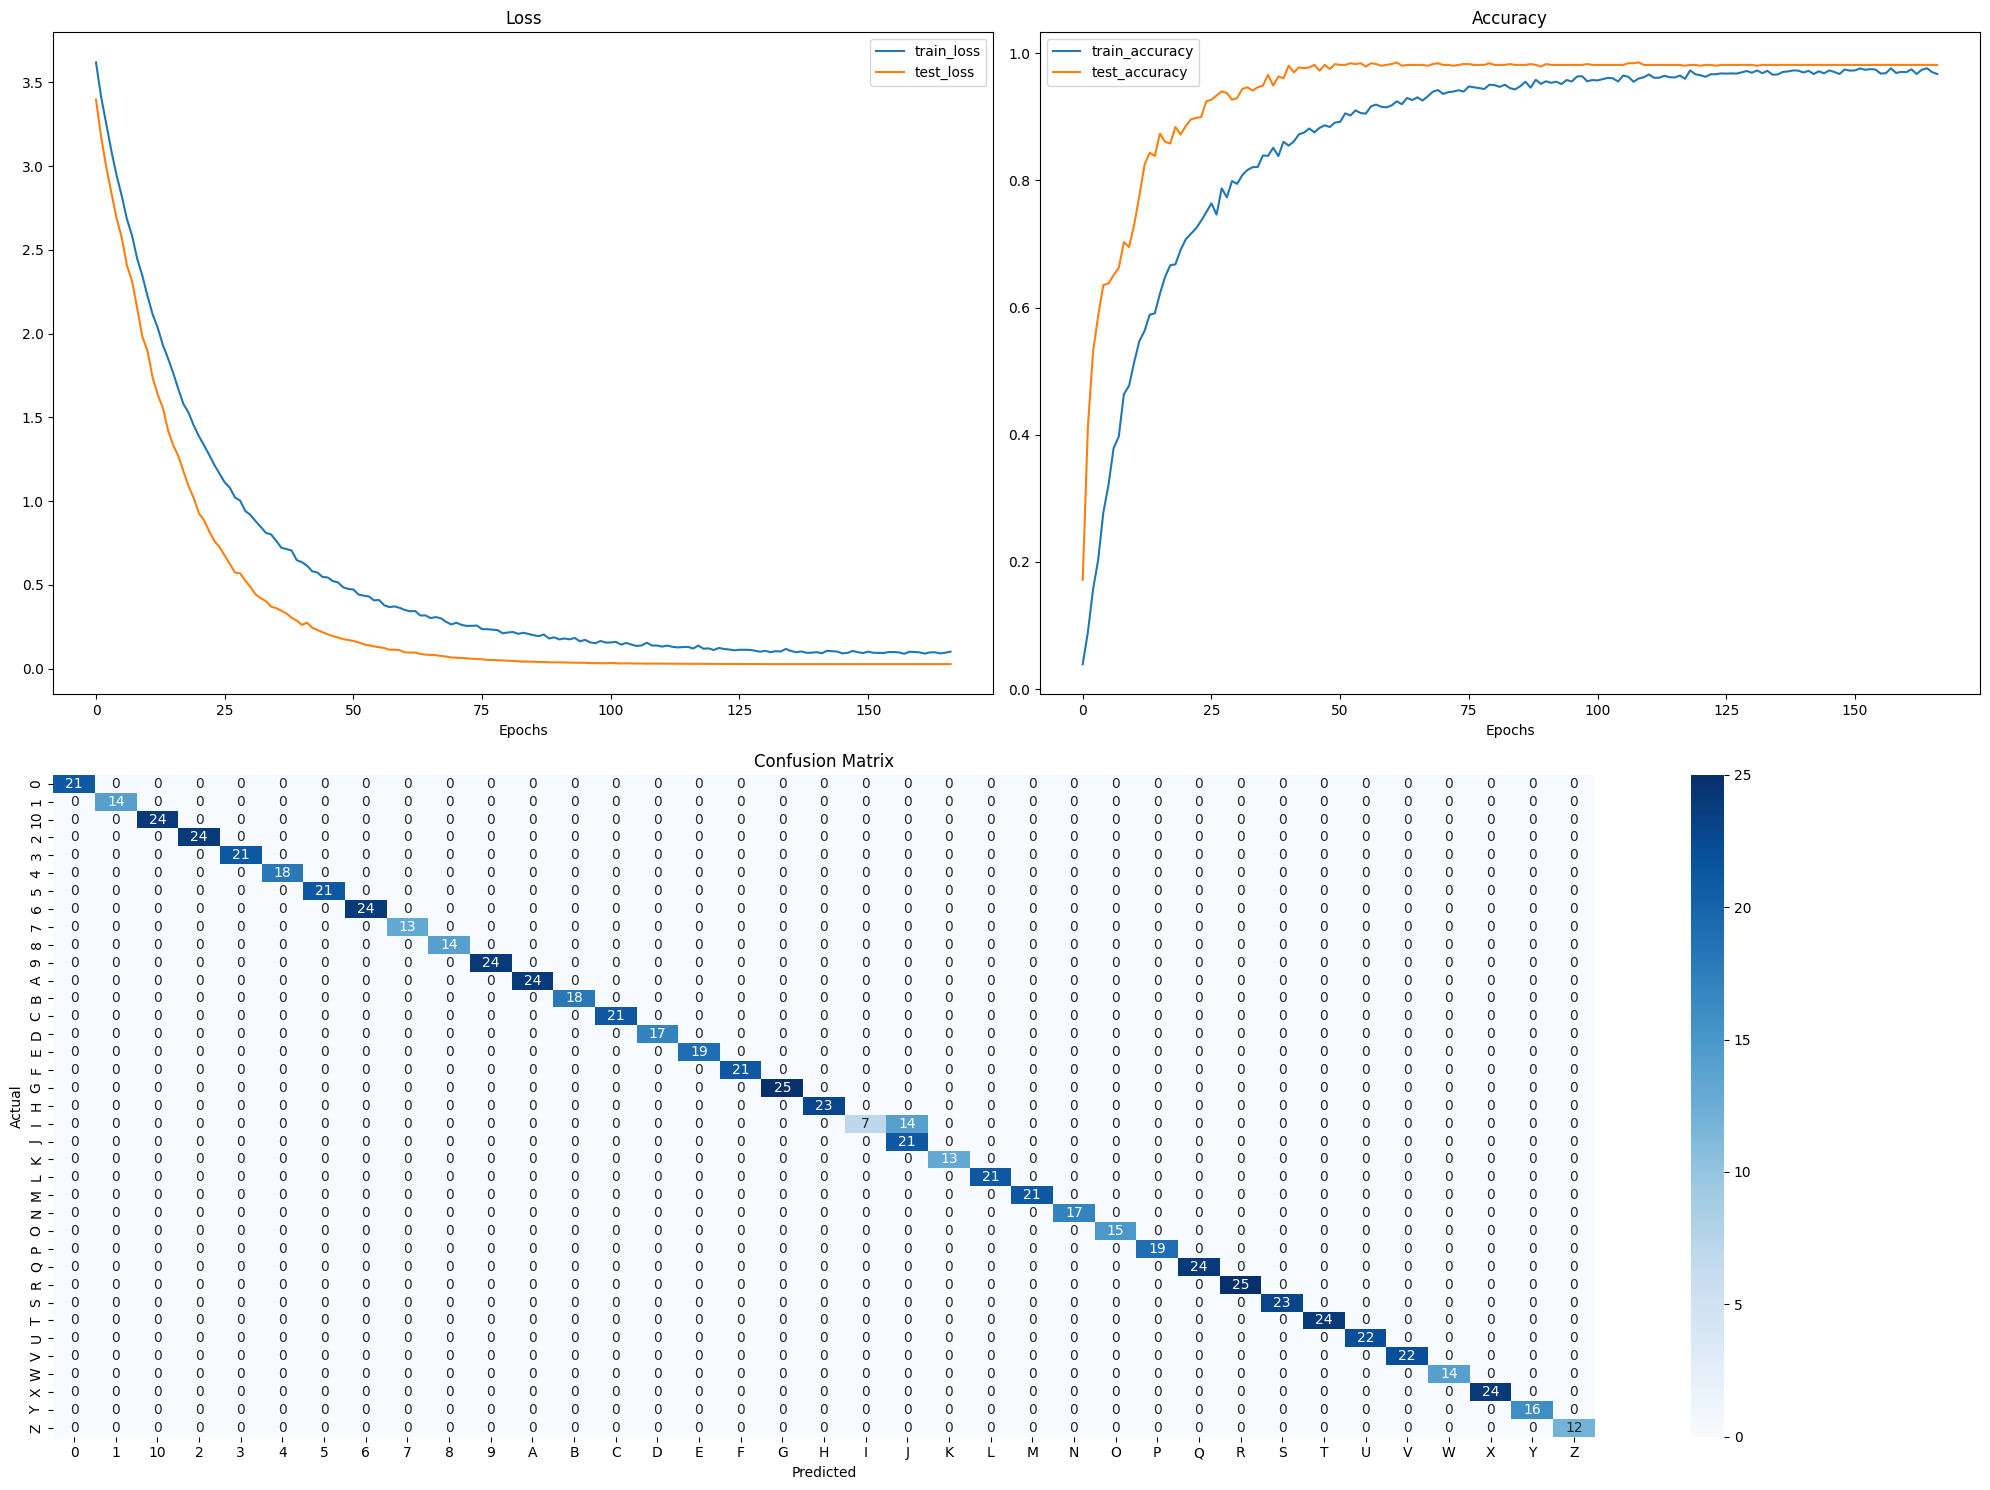

Model saved as 'hand_landmark_model.pth'


In [56]:
from modules.model_trainer import ModelTrainer
from torch.optim.lr_scheduler import ReduceLROnPlateau
from modules.model_performance import ModelPerformanceVisualizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 32
learning_rate = 0.0001
NUM_EPOCHS = 1000
weight_decay = 1e-5  # L2 regularization

dataset = HandLandmarkDataset("Landmarks_DS")
class_names = dataset.get_class_names()
input_size = dataset[0][0].shape[0]  # Get the size of a single input
num_classes = len(dataset.classes)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = HandLandmarkModel(input_size, num_classes)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)


trainer = ModelTrainer()
TRAINED_MODEL, RESULTS = trainer.train(
    model=model,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    optimizer=optimizer,
    loss_fn=criterion,
    epochs=NUM_EPOCHS,
    scheduler=scheduler,
    patience=None 
)


# Plot the results
visualizer = ModelPerformanceVisualizer(RESULTS)
y_true, y_pred = visualizer.get_preds(model=TRAINED_MODEL, dataloader=test_dataloader, device=device)
visualizer.plot_all(y_true=y_true, y_pred=y_pred, classes=class_names, save_path="model_performance/plot.jpg")

# Save the model
torch.save(model.state_dict(), 'hand_landmark_model.pth')
print("Model saved as 'hand_landmark_model.pth'")

In [59]:
from modules.model_saver import ModelSaver

saver = ModelSaver(target_dir="models")
loaded_model = saver.load_model(model=model, model_name="hand_landmark_model.pth")

[INFO] Loading model from: models\hand_landmark_model.pth


In [60]:
from modules.model_eval import ModelEvaluator

evaluator = ModelEvaluator(loaded_model)
results = evaluator.evaluate_and_report(test_dataloader, class_names)

print(f"Accuracy: {results['accuracy']:.4f}")
print("Classification Report:")
print(results['classification_report'])

Accuracy: 0.9811
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        14
          10       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        24
           3       1.00      1.00      1.00        21
           4       1.00      1.00      1.00        18
           5       1.00      1.00      1.00        21
           6       1.00      1.00      1.00        24
           7       1.00      1.00      1.00        13
           8       1.00      1.00      1.00        14
           9       1.00      1.00      1.00        24
           A       1.00      1.00      1.00        24
           B       1.00      1.00      1.00        18
           C       1.00      1.00      1.00        21
           D       1.00      1.00      1.00        17
           E       1.00      1.00      1.00        19
           F       1.00      1.00      1.

In [61]:
def convert_to_torchscript(model, example_input, filename):
    model.eval()  # Set the model to evaluation mode
    
    # Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing
    traced_script_module = torch.jit.trace(model, example_input)
    
    # Save the TorchScript model
    traced_script_module.save(filename)
    print(f"TorchScript model saved to {filename}")

In [ ]:
model = HandLandmarkModel()


# Create an example input
example_input = torch.randn(1, 63)  # Batch size of 1, 63 features

# Convert and save the model
convert_to_torchscript(model, example_input, "hand_landmark_model.ptl")

In [63]:
# Test loading and inference
loaded_model = torch.jit.load("hand_landmark_model.ptl")
test_input = torch.randn(1, 63)
output = loaded_model(test_input)
print(f"Test output shape: {output.shape}")

Test output shape: torch.Size([1, 37])
